# 3. AutoML : Classification des données


<BR>
    
In this example we use the scikit-learn's [digit dataset](http://scikit-learn.org/stable/datasets/index.html#optical-recognition-of-handwritten-digits-dataset) to showcase how you can use AutoML for a simple classification problem.

Make sure you have executed the [00.configuration](00.configuration.ipynb) before running this notebook.

In this notebook you will learn how to:
- Create an `Experiment` in an existing `Workspace`.
- Configure AutoML using `AutoMLConfig`.
- Train the model using local compute.
- Explore the results.
- Test the best fitted model.


## Introduction

Avec Azure ML service :
- Select your experiment type: Classification, Regression or Forecasting<br>
- Data source, formats, and fetch data<br>
- Choose your compute target: local or remote<br>
- Automated machine learning experiment settings<br>
- Run an automated machine learning experiment<br>
- Explore model metrics<br>
- Register and deploy model<br>


Documentation :
> https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-automated-ml

## 1. Informations

As part of the setup you have already created an Azure ML `Workspace` object. For AutoML you will need to create an `Experiment` object, which is a named object in a `Workspace` used to run experiments.

In [1]:
import azureml.core
print("Version Azure ML service :", azureml.core.VERSION)

import sys
print("Version Python : ", sys.version)

Version Azure ML service : 1.0.8
Version Python :  3.6.6 |Anaconda, Inc.| (default, Jun 28 2018, 17:14:51) 
[GCC 7.2.0]


In [2]:
import logging
import os
import random

from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np
import pandas as pd
from sklearn import datasets

import azureml.core
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.train.automl import AutoMLConfig
from azureml.train.automl.run import AutoMLRun

## 2. Connexion workspace Azure ML service

In [3]:
ws = Workspace.from_config()

experiment_name = 'automllocalclustering'
project_folder = './sampleprojects/automllocalclustering'

experiment = Experiment(ws, experiment_name)

output = {}
output['Version Azure ML service : '] = azureml.core.VERSION
output['Nom du workspace : '] = ws.name
output['Ressource groupe : '] = ws.resource_group
output['Localisation : '] = ws.location
output['Répertoire projet : '] = project_folder
output['Nom expérience : '] = experiment.name
pd.set_option('display.max_colwidth', -1)
pd.DataFrame(data = output, index = ['']).T

Found the config file in: /home/nbuser/library/aml_config/config.json


,
Localisation :,westeurope
Nom du workspace :,AMLSworkspace
Nom expérience :,automllocalclustering
Ressource groupe :,resgrpAMLS
Répertoire projet :,./sampleprojects/automllocalclustering
Version Azure ML service :,1.0.8


## Diagnostics

Opt-in diagnostics for better experience, quality, and security of future releases.

In [4]:
from azureml.telemetry import set_diagnostics_collection
set_diagnostics_collection(send_diagnostics = True)

Turning diagnostics collection on. 


## 3. Chargement des données

This uses scikit-learn's [load_digits](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) method.

In [5]:
from sklearn import datasets

digits = datasets.load_digits()

# Exclude the first 100 rows from training so that they can be used for test.
X_train = digits.data[100:,:]
y_train = digits.target[100:]

## 4. Configuration AutoML

Instantiate an `AutoMLConfig` object to specify the settings and data used to run the experiment.

|Property|Description|
|-|-|
|**task**|classification or regression|
|**primary_metric**|This is the metric that you want to optimize. Classification supports the following primary metrics: <br><i>accuracy</i><br><i>AUC_weighted</i><br><i>balanced_accuracy</i><br><i>average_precision_score_weighted</i><br><i>precision_score_weighted</i>|
|**max_time_sec**|Time limit in seconds for each iteration.|
|**iterations**|Number of iterations. In each iteration AutoML trains a specific pipeline with the data.|
|**n_cross_validations**|Number of cross validation splits.|
|**X**|(sparse) array-like, shape = [n_samples, n_features]|
|**y**|(sparse) array-like, shape = [n_samples, ], [n_samples, n_classes]<br>Multi-class targets. An indicator matrix turns on multilabel classification. This should be an array of integers.|
|**path**|Relative path to the project folder. AutoML stores configuration files for the experiment under this folder. You can specify a new empty folder.|

**K-Folds Cross Validation**

Use `n_cross_validations` setting to specify the number of cross validations. The training data set will be randomly split into `n_cross_validations` folds of equal size. During each cross validation round, one of the folds will be used for validation of the model trained on the remaining folds. This process repeats for `n_cross_validations` rounds until each fold is used once as validation set. The average scores across all `cross_validations rounds` will be reported, and the corresponding model will be retrained on the whole training data set.

**Monte Carlo Cross Validation (a.k.a. Repeated Random Sub-Sampling)**

Use `validation_size` to specify the percentage of the training dataset that should be used for validation, and use `n_cross_validations` to specify the number of cross validations. During each cross validation round, a subset of size validation_size will be randomly selected for validation of the model trained on the remaining data. Finally, the average scores across all `n_cross_validations` rounds will be reported, and the corresponding model will be retrained on the whole training data set.

** Métriques disponibles** :<br>`
Accuracy
AUC_weighted
precision_score_weighted
balanced_accuracy
average_precision_score_weighted`


Documentation :
https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-configure-auto-train

### 4.1 Liste des modèles

<img src="https://raw.githubusercontent.com/retkowsky/workshop_AzureMLService/master/Liste%20des%20mod%C3%A8les%20AUTOML.jpg" width="800" height="800">

https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-configure-auto-train

### 4.2 Configuration AutoML

In [6]:
automl_config = AutoMLConfig(task = 'classification',
                             debug_log = 'automl_errors.log',
                             primary_metric = 'AUC_weighted',
                             iteration_timeout_minutes = 10,
                             iterations = 10,
                             n_cross_validations = 3,
                             verbosity = logging.INFO,
                             X = X_train, 
                             y = y_train,
                             path = project_folder)

## 5. AutoML

Call the `submit` method on the experiment object and pass the run configuration. Execution of local runs is synchronous. Depending on the data and the number of iterations this can run for a while.
In this example, we specify `show_output = True` to print currently running iterations to the console.

`AUC_weighted` is the **metric** used.

In [7]:
local_run = experiment.submit(automl_config, show_output = True)

Running on local machine
Parent Run ID: AutoML_378a53c2-7733-499f-8acd-e70cf6808b5d
*******************************************************************************************************
ITERATION: The iteration being evaluated.
PIPELINE: A summary description of the pipeline being evaluated.
TRAINFRAC: Fraction of the training data to train on.
DURATION: Time taken for the current iteration.
METRIC: The result of computing score on the fitted pipeline.
BEST: The best observed score thus far.
*******************************************************************************************************

 ITERATION   PIPELINE                                       TRAINFRAC  DURATION      METRIC      BEST
         0   StandardScalerWrapper KNN                      1.0000     0:00:30       0.9988    0.9988
         1   StandardScalerWrapper KNN                      1.0000     0:00:27       0.9964    0.9988
         2   TruncatedSVDWrapper LightGBM                   1.0000     0:00:25       0.995

In [8]:
local_run

Experiment,Id,Type,Status,Details Page,Docs Page
automllocalclustering,AutoML_378a53c2-7733-499f-8acd-e70cf6808b5d,automl,Completed,Link to Azure Portal,Link to Documentation


Optionally, you can continue an interrupted local run by calling `continue_experiment` without the `iterations` parameter, or run more iterations for a completed run by specifying the `iterations` parameter:

#local_run = local_run.continue_experiment(X = X_train, 
                                          y = y_train, 
                                          show_output = True,
                                          iterations = 5)

In [9]:
#local_run

## 6. Exploration des résultats AutoML

### 6.1 Notebook Widget

The widget will first report a "loading" status while running the first iteration. After completing the first iteration, an auto-updating graph and table will be shown. The widget will refresh once per minute, so you should see the graph update as child runs complete.

**Note:** The widget displays a link at the bottom. Use this link to open a web interface to explore the individual run details.

In [10]:
from azureml.widgets import RunDetails
RunDetails(local_run).show() 

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': True, 'log_level': 'INFO', 'sd…


### 6.2 Métriques par itération


In [11]:
children = list(local_run.get_children())
metricslist = {}
for run in children:
    properties = run.get_properties()
    metrics = {k: v for k, v in run.get_metrics().items() if isinstance(v, float)}
    metricslist[int(properties['iteration'])] = metrics

rundata = pd.DataFrame(metricslist).sort_index(1)
rundata

,0,1,2,3,4,5,6,7,8,9
AUC_macro,0.998831,0.996460,0.995278,0.998493,0.998494,0.997816,0.999427,0.999441,0.996619,0.999743
AUC_micro,0.999016,0.996402,0.995471,0.998777,0.998573,0.997816,0.999440,0.999467,0.996997,0.999813
AUC_weighted,0.998831,0.996386,0.995303,0.998467,0.998492,0.997782,0.999420,0.999439,0.996640,0.999737
accuracy,0.965236,0.987034,0.915147,0.964059,0.951091,0.974661,0.971720,0.975256,0.938722,0.988216
average_precision_score_macro,0.993350,0.988395,0.971212,0.990909,0.988972,0.992957,0.995843,0.996058,0.980108,0.998339
average_precision_score_micro,0.994107,0.988071,0.973481,0.992053,0.989024,0.992539,0.995937,0.996248,0.981398,0.998636
average_precision_score_weighted,0.993454,0.988216,0.971513,0.990806,0.989008,0.992778,0.995853,0.996089,0.980327,0.998307
balanced_accuracy,0.965062,0.987092,0.915614,0.965364,0.951313,0.974766,0.972403,0.975696,0.939286,0.988719
f1_score_macro,0.965093,0.987168,0.914511,0.964775,0.950920,0.974650,0.972247,0.975713,0.938919,0.988536
f1_score_micro,0.965236,0.987034,0.915147,0.964059,0.951091,0.974661,0.971720,0.975256,0.938722,0.988216


## 7. Récupération du meilleur modèle

Below we select the best pipeline from our iterations. The `get_output` method returns the best run and the fitted model. The Model includes the pipeline and any pre-processing.  Overloads on `get_output` allow you to retrieve the best run and fitted model for *any* logged metric or for a particular *iteration*.

In [12]:
best_run, fitted_model = local_run.get_output()
print(best_run)
print(fitted_model)

Run(Experiment: automllocalclustering,
Id: AutoML_378a53c2-7733-499f-8acd-e70cf6808b5d_9,
Type: None,
Status: Completed)
Pipeline(memory=None,
     steps=[('prefittedsoftvotingclassifier', PreFittedSoftVotingClassifier(classification_labels=None,
               estimators=[('LogisticRegression', Pipeline(memory=None,
     steps=[('StandardScalerWrapper', <automl.client.core.common.model_wrappers.StandardScalerWrapper object at 0x7fa6c47e2780>),...))],
               flatten_transform=None,
               weights=[0.1, 0.3, 0.1, 0.1, 0.1, 0.3]))])


### 7.1 Changement de la métrique AutoML


In [13]:
lookup_metric = "f1_score_weighted"
best_run, fitted_model = local_run.get_output(metric = lookup_metric)
print(best_run)
print(fitted_model)

Run(Experiment: automllocalclustering,
Id: AutoML_378a53c2-7733-499f-8acd-e70cf6808b5d_9,
Type: None,
Status: Completed)
Pipeline(memory=None,
     steps=[('prefittedsoftvotingclassifier', PreFittedSoftVotingClassifier(classification_labels=None,
               estimators=[('LogisticRegression', Pipeline(memory=None,
     steps=[('StandardScalerWrapper', <automl.client.core.common.model_wrappers.StandardScalerWrapper object at 0x7fa6c595f2b0>),...))],
               flatten_transform=None,
               weights=[0.1, 0.3, 0.1, 0.1, 0.1, 0.3]))])


Model from a Specific Iteration
Show the run and the model from the third iteration:

In [14]:
iteration = 3
third_run, third_model = local_run.get_output(iteration = iteration)
print(third_run)
print(third_model)

Run(Experiment: automllocalclustering,
Id: AutoML_378a53c2-7733-499f-8acd-e70cf6808b5d_3,
Type: None,
Status: Completed)
Pipeline(memory=None,
     steps=[('StandardScalerWrapper', <automl.client.core.common.model_wrappers.StandardScalerWrapper object at 0x7fa6c591a4a8>), ('LogisticRegression', LogisticRegression(C=6866.488450042998, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=None, solver='saga', tol=0.0001, verbose=0,
          warm_start=False))])


## 8. Test du modèle

### 8.1 Chargement des données

In [15]:
digits = datasets.load_digits()
X_test = digits.data[:10, :]
y_test = digits.target[:10]
images = digits.images[:10]

### 8.2 Test
We will try to predict 2 digits and see how our model works.

4


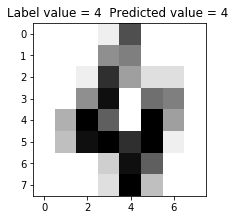

0


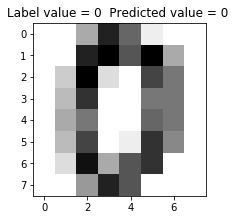

In [16]:
# Randomly select digits and test.
for index in np.random.choice(len(y_test), 2, replace = False):
    print(index)
    predicted = fitted_model.predict(X_test[index:index + 1])[0]
    label = y_test[index]
    title = "Label value = %d  Predicted value = %d " % (label, predicted)
    fig = plt.figure(1, figsize = (3,3))
    ax1 = fig.add_axes((0,0,.8,.8))
    ax1.set_title(title)
    plt.imshow(images[index], cmap = plt.cm.gray_r, interpolation = 'nearest')
    plt.show()

** Documentation disponible :**
    https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-configure-auto-train

> Fin